In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
import numpy as np
from spectogram_script import load_all, epochs_as_rows
from plotting import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
freqs, dataDict = load_all()

In [4]:
animal, epochs = "NPR052e.10", {
    channel: values
    for channel, values in dataDict["NPR052e.10"].items()
}

In [5]:
channel_n = epochs[sorted(epochs.keys())[0]].shape[0]
channels_n = len(epochs.keys())
print(channel_n)
print(channels_n)

780
15


In [6]:
fidx = ((freqs > 5) & (freqs < 50))
freqs = freqs[fidx]
epochs = {
    k: v[ : , fidx] for k, v in epochs.items() 
}
features_n = epochs[sorted(epochs.keys())[0]].shape[1]

In [7]:
channel = sorted(epochs.keys())[0]
values = epochs[channel]

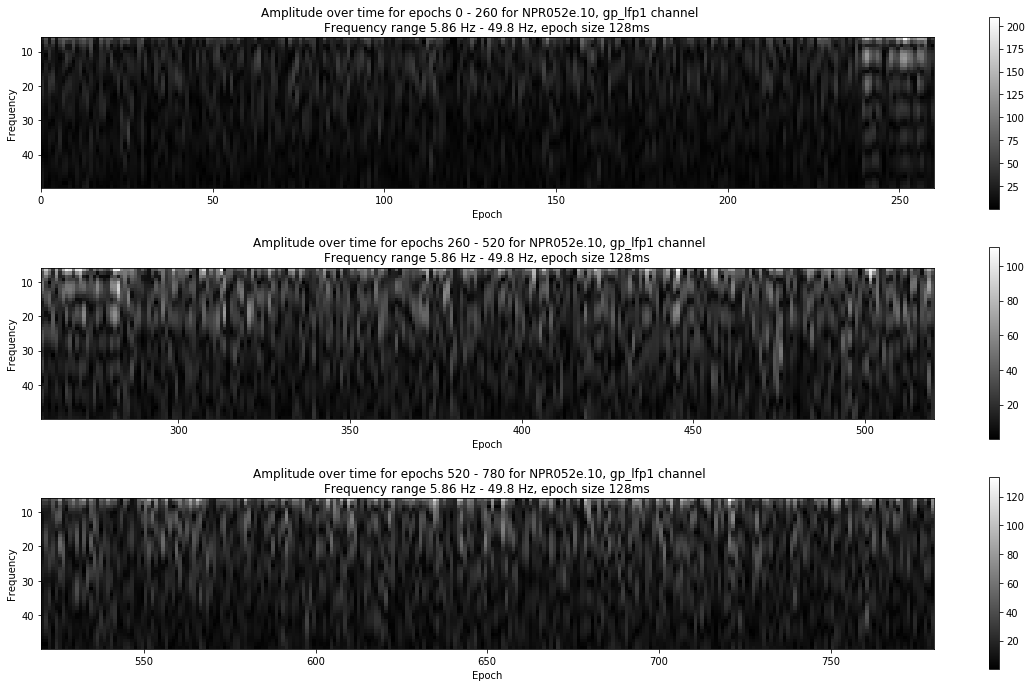

In [8]:
plt.figure(figsize = (20, 12))
maxn = 3
stepn = int(channel_n / maxn)
for step in range(0, maxn):
    
    lo = step * stepn
    hi = (step + 1) * stepn
    lof = round(np.min(freqs), 2)
    hif = round(np.max(freqs), 2)

    plt.subplot(maxn, 1, step + 1)
    plt.title(f"Amplitude over time for epochs {lo} - {hi} for {animal}, {channel} channel\
    \nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms")
    plt.xlabel("Epoch")
    plt.ylabel("Frequency")
    plt.imshow(
        values.transpose()[ : , lo : hi],
        cmap = 'gray',
        extent = [
            lo, hi, hif, lof
        ]
    )
    plt.colorbar()
    
plt.savefig("../_data/FFV-KMeans/FFV.png")
plt.show()

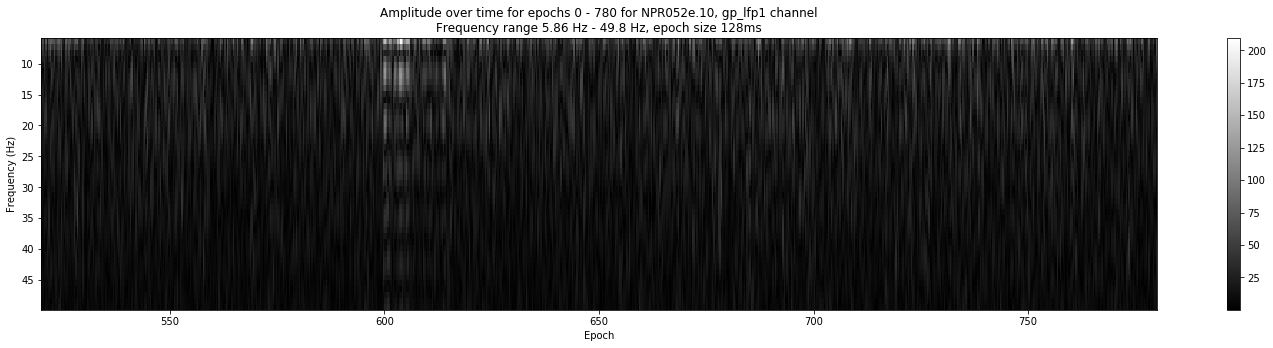

In [9]:
plt.figure(figsize = (25, 5))
plt.title(f"Amplitude over time for epochs 0 - {channel_n} for {animal}, {channel} channel" + \
    f"\nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms")
plt.xlabel("Epoch")
plt.ylabel("Frequency (Hz)")
plt.imshow(
    values.transpose(),
    cmap = 'gray',
    extent = [
        lo, hi, hif, lof
    ],
    aspect = 'auto'
)
plt.colorbar()
plt.savefig("../_data/FFV-KMeans/exampleSpect.png")
plt.show()

In [8]:
epochs_all = np.concatenate([
    epochs[k] for k in sorted(epochs.keys())
], axis = 0)
print(epochs_all.shape)
print(sorted(epochs.keys()))

(11700, 46)
['gp_lfp1', 'gp_lfp10', 'gp_lfp11', 'gp_lfp2', 'gp_lfp3', 'gp_lfp4', 'gp_lfp5', 'gp_lfp6', 'gp_lfp7', 'gp_lfp8', 'gp_lfp9', 'str_lfp13', 'str_lfp14', 'str_lfp15', 'str_lfp16']


In [9]:
from sklearn.cluster import KMeans

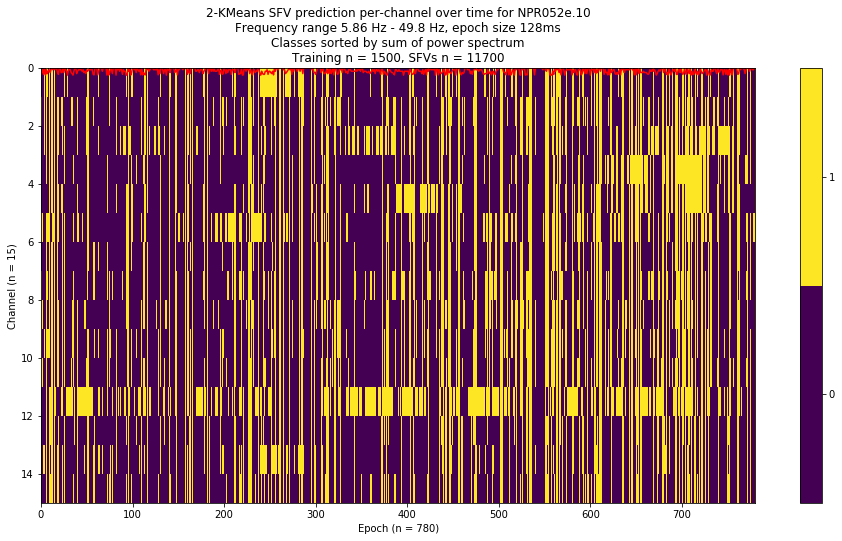

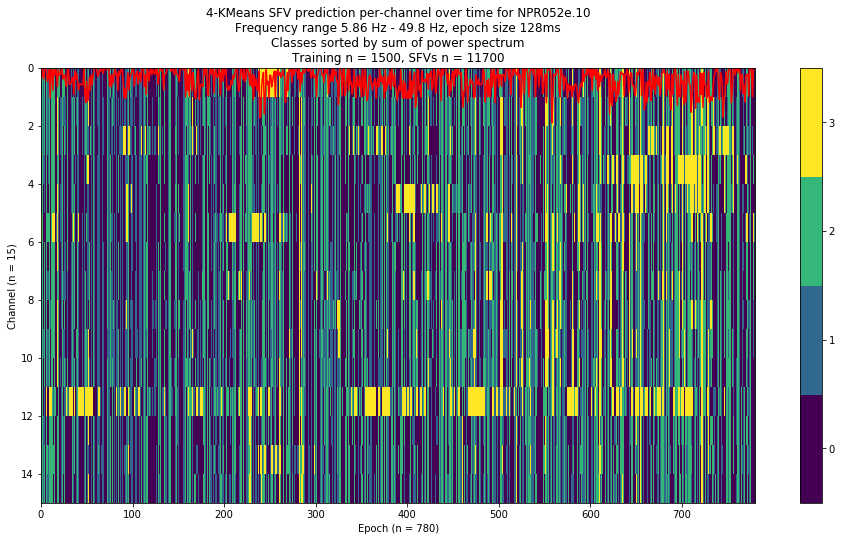

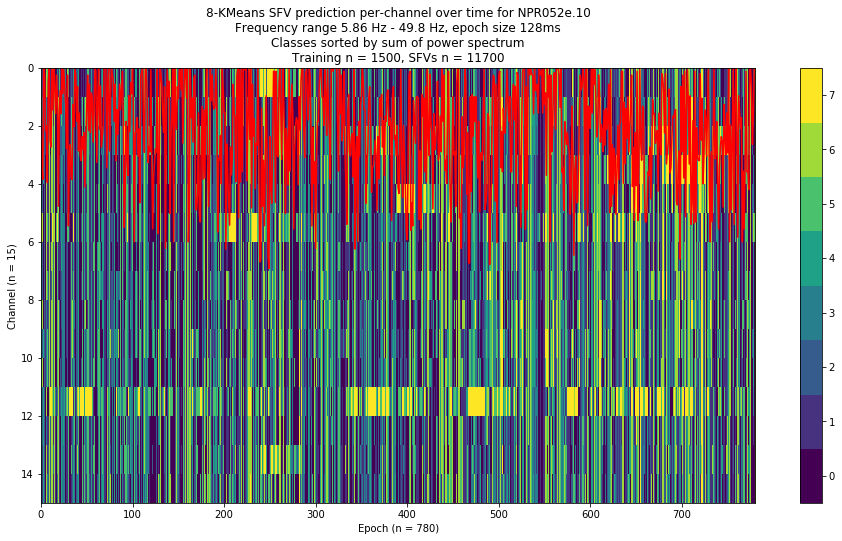

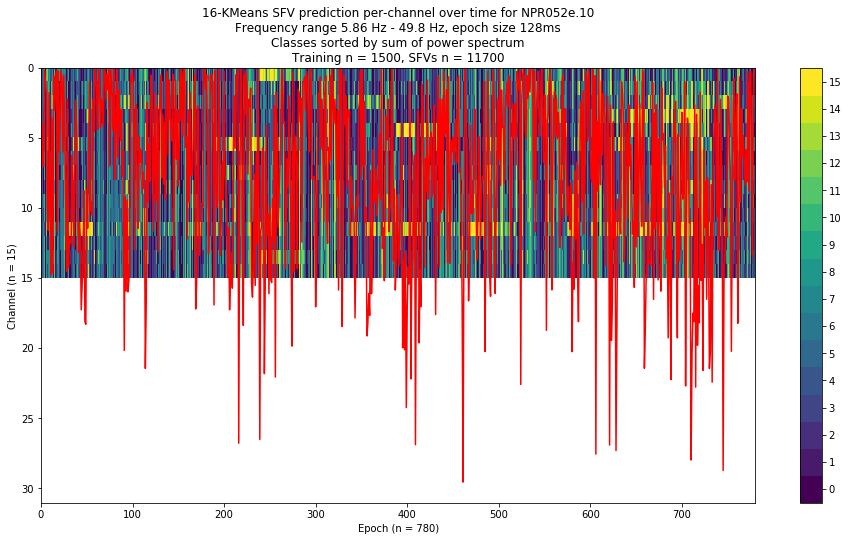

In [25]:
from random import sample

for k in [2, 4, 8, 16]:
    
    training_n = 1500
    training = np.array([
        a for a in sample(list(epochs_all), training_n)
    ])
    
    kmeans_model = KMeans(n_clusters = k).fit(training)
    predictions = kmeans_model.predict(epochs_all).reshape((-1, channel_n))
    lof = round(np.min(freqs), 2)
    hif = round(np.max(freqs), 2)
    
    kmfigsz = (16, 8)

    plt.figure(figsize = kmfigsz)
    plt.title(
        f"{k}-KMeans SFV prediction per-channel over time for {animal}" + \
        f"\nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms" + \
        f"\nClass color assignment not indicative of class similarity" + \
        f"\nTraining n = {training_n}, SFVs n = {channel_n * channels_n}"
    )
    plt.xlabel(f"Epoch (n = {channel_n})")
    plt.ylabel(f"Channel (n = {channels_n})")
    plt.imshow(
        predictions,
        cmap = plt.get_cmap(
            'viridis', 
            np.max(predictions) - np.min(predictions) + 1
        ),
        extent = [
            0, channel_n, channels_n, 0
        ],
        aspect = 'auto',
        vmin = np.min(predictions) -.5,
        vmax = np.max(predictions) +.5
    )
    plt.colorbar(ticks = np.arange(0, k))
    plt.savefig(f"../_data/FFV-KMeans/KMeans{k}.png")
    plt.close()
    
#     mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
#     #tell the colorbar to tick at integers
#     cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))
    
    ##############
    
    cluster_centers = np.array([sorted(
        kmeans_model.cluster_centers_,
        key = lambda v: (v**2).sum()
    )]).reshape((k, -1))
        
    pred = []
    for ep in epochs_all:
        mind, mini = 1e10, -1
        for i, c in enumerate(cluster_centers):
            d = c - ep
            d = (d**2).sum()
            if d < mind:
                mind, mini = d, i
        pred.append(mini)
    pred = np.array(pred).reshape((-1, channel_n))
    
    plt.figure(figsize = kmfigsz)
    plt.title(
        f"{k}-KMeans SFV prediction per-channel over time for {animal}" + \
        f"\nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms" + \
        f"\nClasses sorted by sum of power spectrum" + \
        f"\nTraining n = {training_n}, SFVs n = {channel_n * channels_n}"
    )
    plt.xlabel(f"Epoch (n = {channel_n})")
    plt.ylabel(f"Channel (n = {channels_n})")
    plt.imshow(
        pred,
        extent = [
            0, channel_n, channels_n, 0
        ],
        cmap = plt.get_cmap(
            'viridis', 
            np.max(pred) - np.min(pred) + 1
        ),
        aspect = 'auto',
        vmin = np.min(pred) -.5,
        vmax = np.max(pred) +.5
    )
    plt.colorbar(ticks = np.arange(0, k))
    plt.plot(pred.var(axis = 0), 'r')
    plt.show()
    plt.savefig(f"../_data/FFV-KMeans/KMeans{k}power.png")
    plt.close()
    
    #############
    
    plt.figure(figsize = (20, 10))
    plt.plot(pred[0, : int(channel_n / 3)])
    plt.title(
        f"{k}-KMeans SFV prediction for specific channel over time for {animal}" + \
        f"\nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms" + \
        f"\nClasses sorted by sum of power spectrum" + \
        f"\nTraining n = {training_n}, SFVs n = {channel_n * channels_n}"
    )
    plt.xlabel(f"Epoch (n = {channel_n})")
    plt.ylabel(f"Class prediction (n classes = {k})")
    plt.savefig(f"../_data/FFV-KMeans/KMeans{k}specific.png")
    plt.close()
    
    ###############
    
    plt.figure(figsize = (20, k * 6))
    plt.title(f"Cluster centers sorted by sum of power spectrum")
    for idx, c in enumerate(cluster_centers):
        plt.subplot(k, 1, idx + 1)
        plt.plot(freqs, c)
        plt.plot(freqs, c, 'x')
    plt.savefig(f"../_data/FFV-KMeans/KMeans{k}centers.png")
    plt.close()

In [20]:
print(sorted(epochs.keys()))
print(len(sorted(epochs.keys())))

srt = sorted(epochs.keys())
print(srt[20])
print(srt[21])
print(srt[31])

['gp_lfp1', 'gp_lfp10', 'gp_lfp11', 'gp_lfp12', 'gp_lfp13', 'gp_lfp14', 'gp_lfp15', 'gp_lfp16', 'gp_lfp17', 'gp_lfp18', 'gp_lfp19', 'gp_lfp2', 'gp_lfp20', 'gp_lfp21', 'gp_lfp22', 'gp_lfp23', 'gp_lfp24', 'gp_lfp25', 'gp_lfp26', 'gp_lfp27', 'gp_lfp28', 'gp_lfp29', 'gp_lfp3', 'gp_lfp30', 'gp_lfp31', 'gp_lfp32', 'gp_lfp4', 'gp_lfp5', 'gp_lfp6', 'gp_lfp7', 'gp_lfp8', 'gp_lfp9']
32
gp_lfp28
gp_lfp29
gp_lfp9


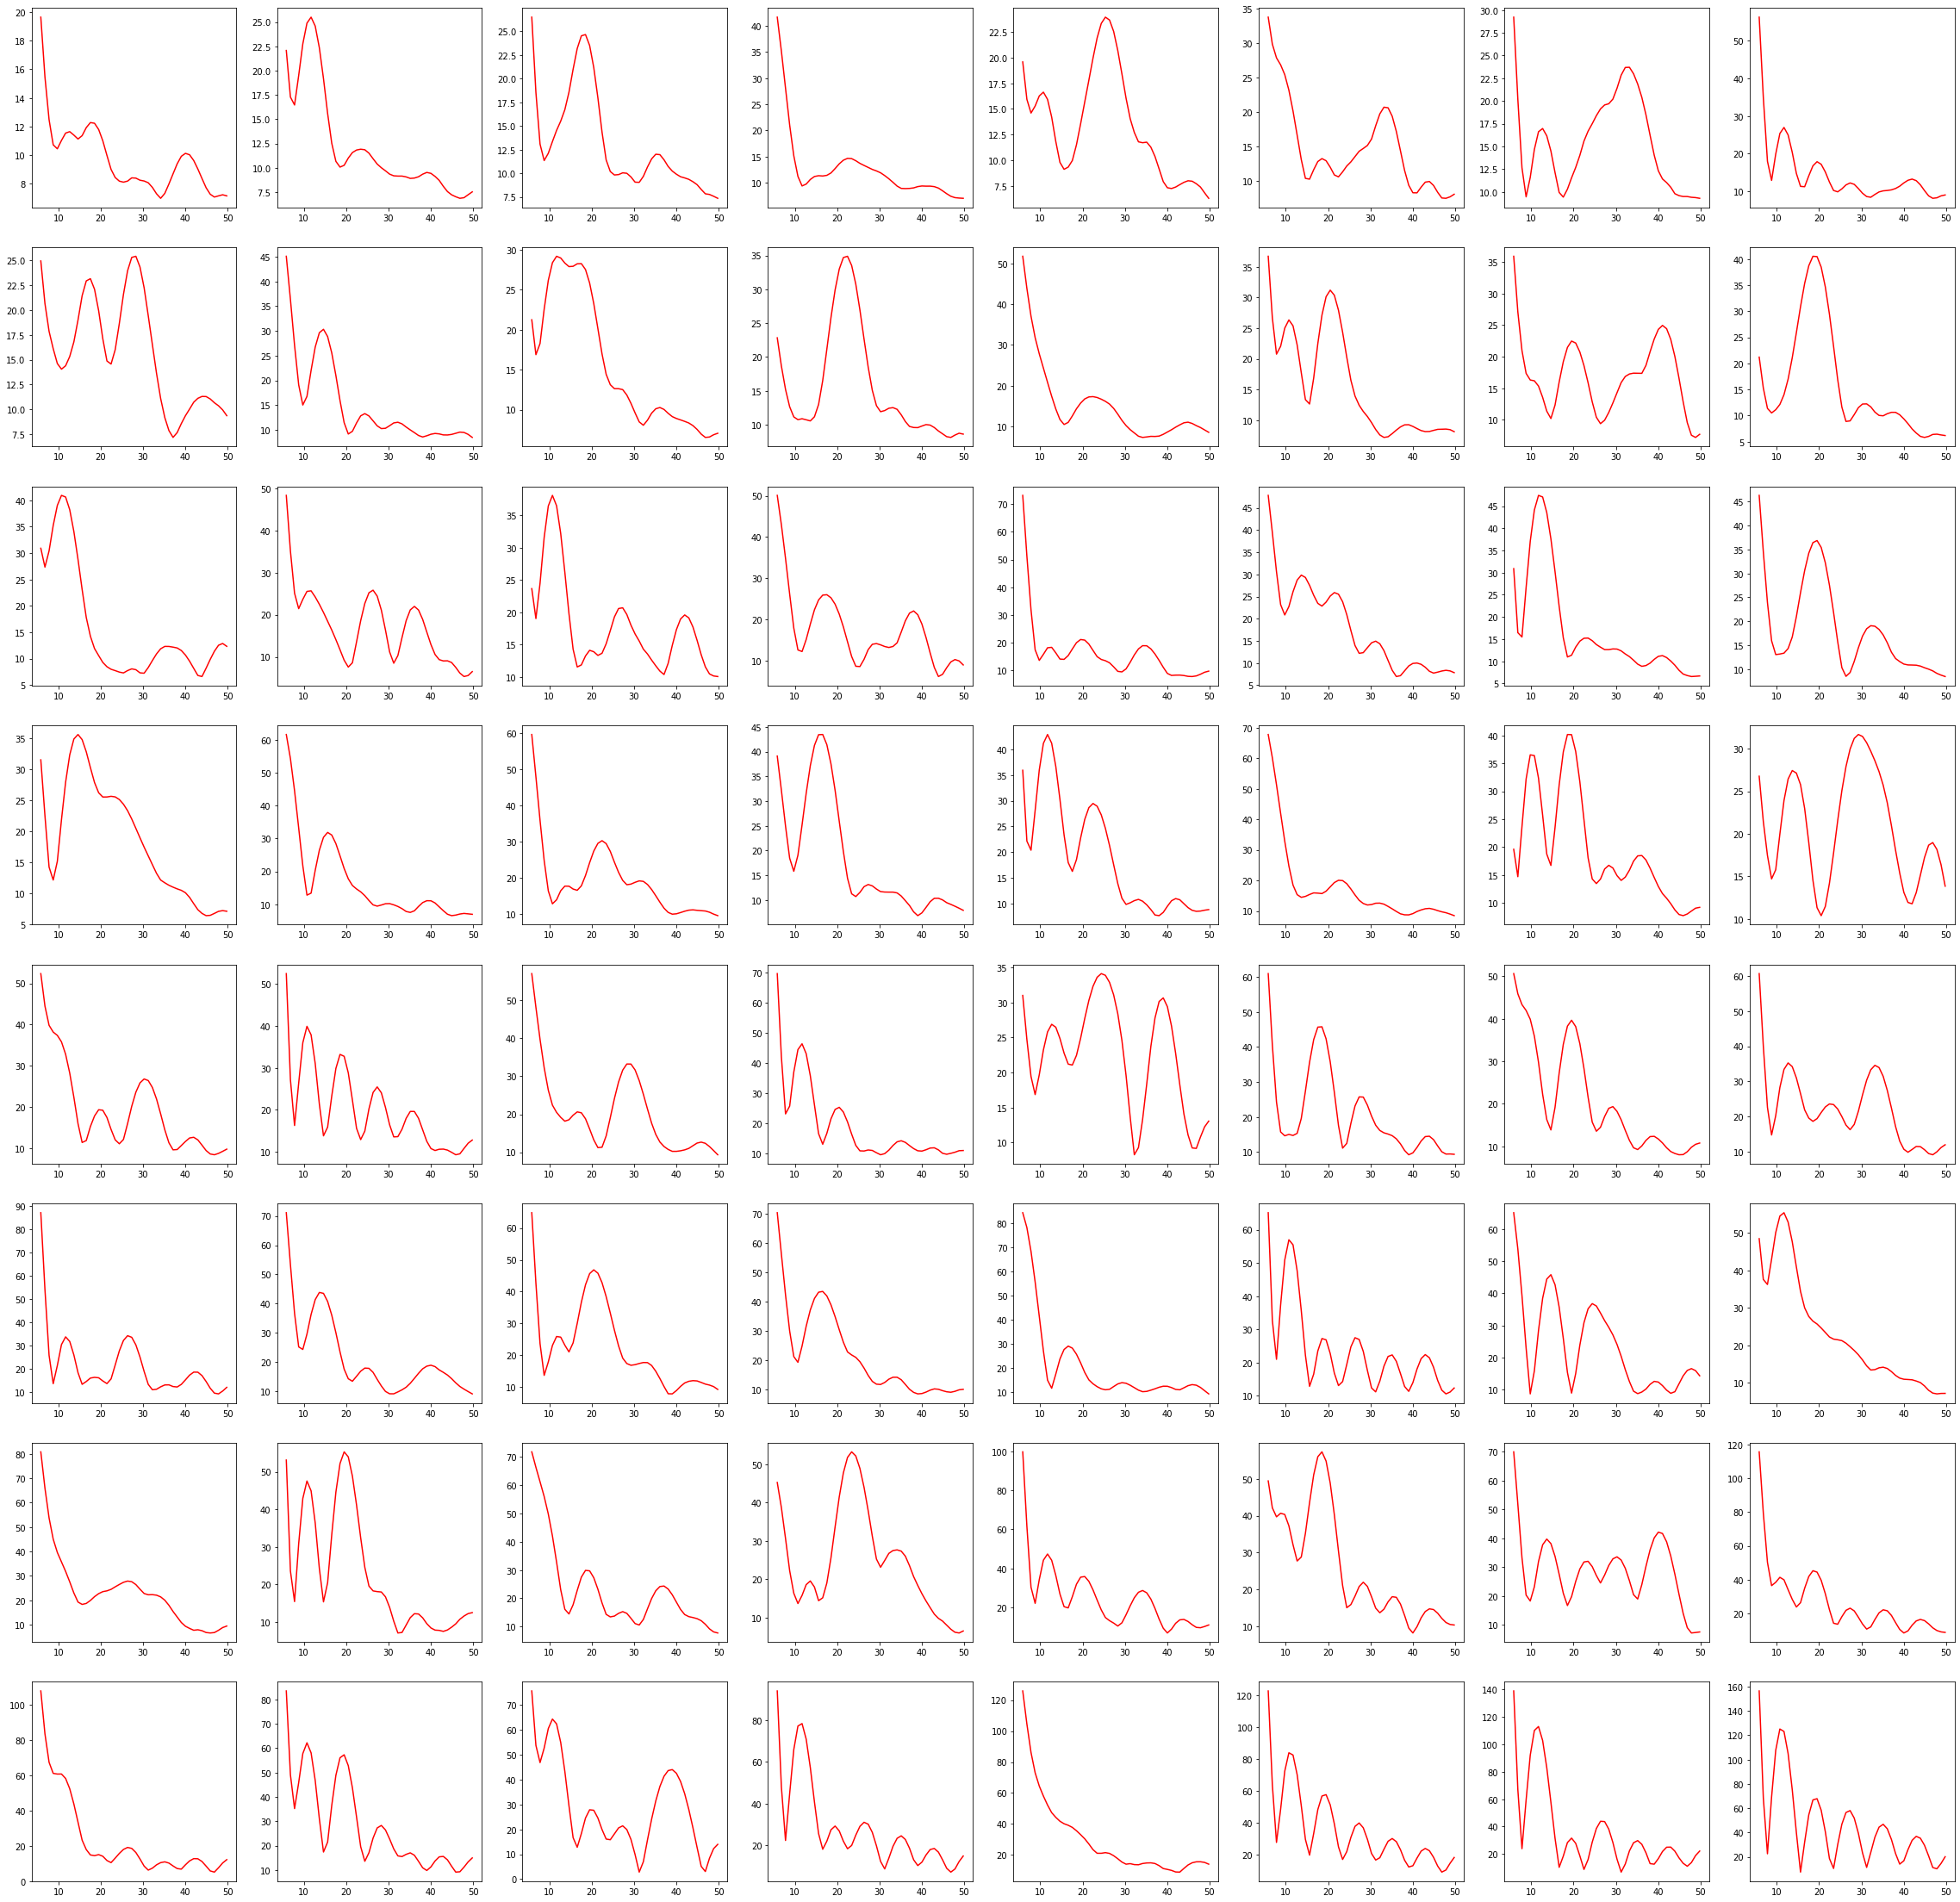

In [48]:
def entropy(v):
    u = v / v.sum()
    return - np.array([
        p * np.log2(p) for p in u
    ]).sum()
    
# i = 1
# plt.figure(figsize = (40, 20))
# for c in sorted(kmeans_model.cluster_centers_, key = lambda v: entropy(v**2)):
#     plt.subplot(4, 8, i)
#     i += 1
#     plt.plot(freqs, c)
# plt.show()

i = 1
plt.figure(figsize = (40, 40))
for c in sorted(kmeans_model.cluster_centers_, key = lambda v: (v**2).sum()):
    plt.subplot(8, 8, i)
    i += 1
    plt.plot(freqs, c, 'r')
plt.show()